
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain daily SLP predictor (KMA guided with nearshore runup) and associated offshore wave conditions. 
### Based on Camus et al. (2014), Hegermiller et al. (2017) and Rueda et al. (2017)


inputs required: 
  * ESTELA fields for the site location
  * SLP fields from CFSR reanalysis
  * Offshore historical waves
  * Nearshore reconstructed historical waves at 3 locations
  * Historical runup at 3 locations
  * Historical TCs inside radio 14 
  
in this notebook:
  * Construct daily SLP predictor
  * Obtain Daily Weather Types (DWT) and probabilities of occurrence (KMA regression guidded with runup)
  * Obtain intradaily hydrographs for the 3 locations (just for validation purposes)
  * Associate offshore wave conditions to each DWT

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import datetime

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.estela import spatial_gradient, Predictor
from teslakit.util.time_operations import xds_common_dates_daily

from teslakit.plotting.estela import Plot_ESTELA
from teslakit.plotting.waves import Plot_Waves_DWTs



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN_hindcast')


In [3]:
# --------------------------------------
# load data and set parameters

ESTELA = db.Load_ESTELA_data()            # ESTELA D data
SLP = db.Load_ESTELA_SLP()                # ESTELA Sea Level Pressure

WAVES = db.Load_WAVES_hist()              # Historical offshore CSIRO waves

_, TCs_r1_params = db.Load_TCs_r1_hist()  # TCs historical parameters inside 14º radius 


# --------------------------------------
# Load hourly runup
WAVES_runup_N = xr.open_dataset('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN_hindcast/HYCREWW/hist_runup_N.nc') # hourly
WAVES_runup_S = xr.open_dataset('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN_hindcast/HYCREWW/hist_runup_S.nc') # 3-hourly
WAVES_runup_E = xr.open_dataset('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN_hindcast/HYCREWW/hist_runup_E.nc') # 3-hourly


# --------------------------------------
# Load nearshore hourly waves
WAVES_N = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/waves_nearshore/v4/output_Def_swells/swells_profiles_N.nc') # hourly
WAVES_S = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/waves_nearshore/v4/output_Def_swells/swells_profiles_S.nc') # 3-hourly
WAVES_E = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/waves_nearshore/v4/output_Def_swells/swells_profiles_E.nc') # 3-hourly


# N, S, E profiles (same profiles selected for runup estimation)
pN = 28 #(36,22)
pS = 8  #(13,1)
pE = 16 #(21,14)

WAVES_N = WAVES_N.sel(profile=pN)
WAVES_S = WAVES_S.sel(profile=pS)
WAVES_E = WAVES_E.sel(profile=pE)

WAVES_N = WAVES_N.drop('profile')
WAVES_S = WAVES_S.drop('profile')
WAVES_E = WAVES_E.drop('profile')

WAVES_N = WAVES_N.rename_vars({"hs":"Hs", "tp":"Tp", 'dir':'Dir'})  # rename vars
WAVES_S = WAVES_S.rename_vars({"hs":"Hs", "tp":"Tp", 'dir':'Dir'})  # rename vars
WAVES_E = WAVES_E.rename_vars({"hs":"Hs", "tp":"Tp", 'dir':'Dir'})  # rename vars


# --------------------------------------
# KMA REGRESSION GUIDED parameters
kma_date_ini = '1979-01-01'
kma_date_end = '2019-12-31'
num_clusters = 36
kmarg_alpha = 0.3



## ESTELA Predictor - Sea Level Pressure and Gradient

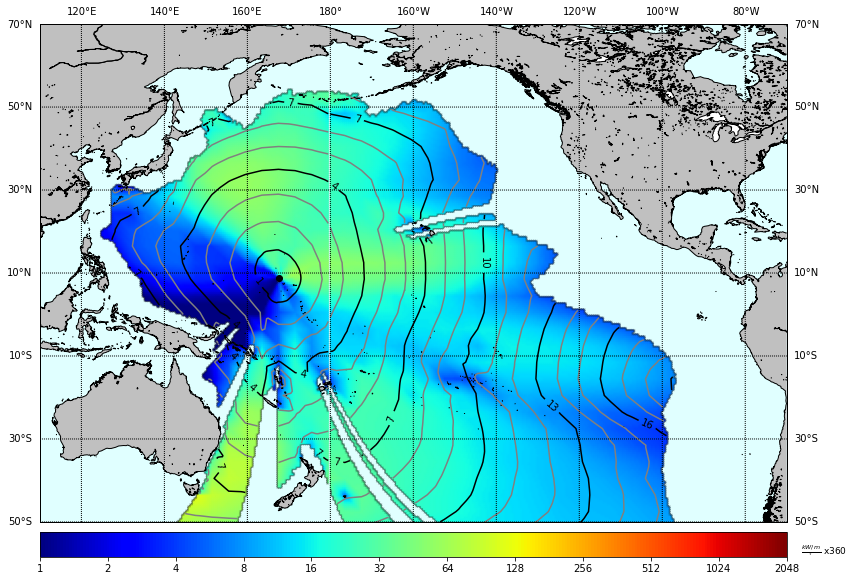

In [4]:
# --------------------------------------
# Plot ESTELA and wave point coordinates

mask_plot = ESTELA.mask_e95

Plot_ESTELA(
    ESTELA.pnt_longitude, ESTELA.pnt_latitude,
    ESTELA.F_y1993to2012 * mask_plot, 
    ESTELA.D_y1993to2012 * mask_plot,
    lon1 = 110, lon2 = 290, lat1 = -50, lat2 = 70,
);


In [4]:
# --------------------------------------
# calculate mean runup from 3 locations, resample to daily (from hourly and 3-hourly)

# Calculate daily mean
WAVES_runup_N_daily = WAVES_runup_N.runup.resample(time='1D').mean()
WAVES_runup_S_daily = WAVES_runup_S.runup.resample(time='1D').mean()
WAVES_runup_E_daily = WAVES_runup_E.runup.resample(time='1D').mean()


# select time window 
WAVES_runup_N_daily = WAVES_runup_N_daily.sel(time = slice(kma_date_ini, kma_date_end))
WAVES_runup_S_daily = WAVES_runup_S_daily.sel(time = slice(kma_date_ini, kma_date_end))
WAVES_runup_E_daily = WAVES_runup_E_daily.sel(time = slice(kma_date_ini, kma_date_end))


# mean runup from 3 points
RUNUP = (WAVES_runup_N_daily + WAVES_runup_S_daily  + WAVES_runup_E_daily)/3.0
RUNUP = RUNUP.to_dataset()    

print(RUNUP)


<xarray.Dataset>
Dimensions:  (time: 14975)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
Data variables:
    runup    (time) float64 1.137 1.782 1.996 1.669 ... 1.188 1.152 1.172 1.34


(725372.0, 726103.0)

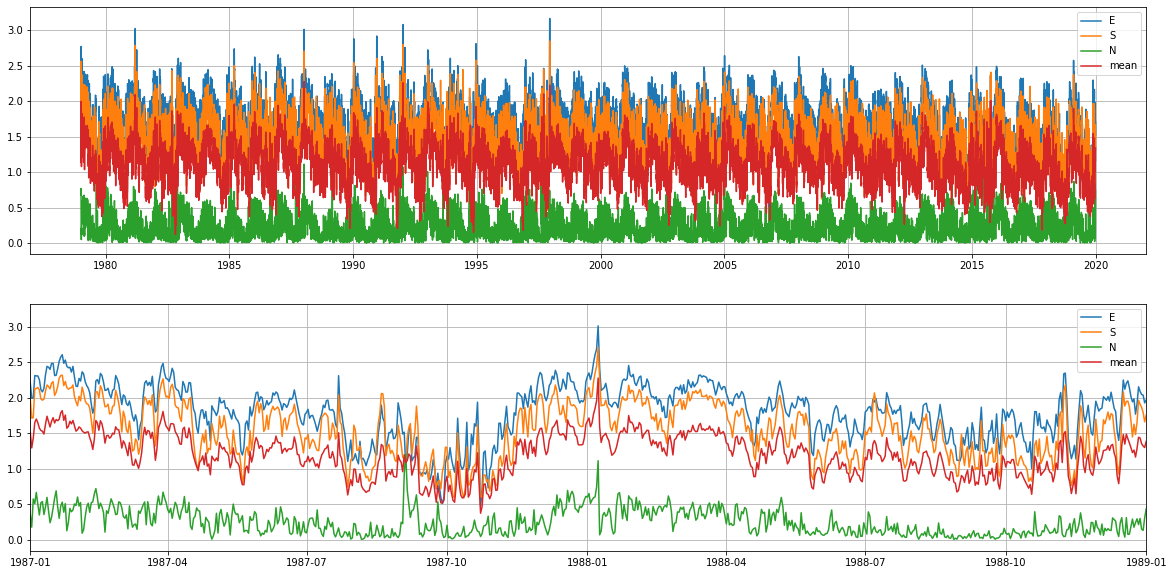

In [6]:
# plot runup

fig, axs = plt.subplots(2,1, figsize=(20,10))

axs[0].plot(WAVES_runup_E_daily.time, WAVES_runup_E_daily, label='E')
axs[0].plot(WAVES_runup_S_daily.time, WAVES_runup_S_daily, label='S')
axs[0].plot(WAVES_runup_N_daily.time, WAVES_runup_N_daily, label='N')
axs[0].plot(RUNUP.time, RUNUP.runup, label='mean')
axs[0].legend()
axs[0].grid()

axs[1].plot(WAVES_runup_E_daily.time, WAVES_runup_E_daily, label='E')
axs[1].plot(WAVES_runup_S_daily.time, WAVES_runup_S_daily, label='S')
axs[1].plot(WAVES_runup_N_daily.time, WAVES_runup_N_daily, label='N')
axs[1].plot(RUNUP.time, RUNUP.runup, label='mean')
axs[1].legend()
axs[1].grid()
axs[1].set_xlim(datetime.datetime(1987,1,1),datetime.datetime(1989,1,1))


In [5]:
# --------------------------------------
# Calculate site SLP & SLP_gradient (daily)

# select time window and do data daily mean
SLP_d = SLP.sel(time = slice(kma_date_ini, kma_date_end)).resample(time='1D').mean()

# calculate daily gradients
SLP_d = spatial_gradient(SLP_d, 'SLP')

print(SLP_d)
    

<xarray.Dataset>
Dimensions:       (latitude: 80, longitude: 96, time: 14975)
Coordinates:
  * time          (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
  * longitude     (longitude) float32 100.0 102.0 104.0 ... 286.0 288.0 290.0
  * latitude      (latitude) float32 80.0 78.0 76.0 74.0 ... -74.0 -76.0 -78.0
Data variables:
    SLP           (time, latitude, longitude) float64 9.946e+04 ... 9.999e+04
    SLP_gradient  (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0



## ESTELA Predictor - Principal Component Analysis

In [8]:
# --------------------------------------
# remove sectors from which waves do not arrive to site
# W=0º, N=-90º, W=180º, S=90º

def cart2pol(a, b):
    '''Output in degrees'''
    # convert to geographic convention
    module = np.sqrt(a**2 + b**2)
    direction = np.arctan2(b, a)
    direction = np.degrees(direction)

    return module, direction


[lon, lat] = np.meshgrid(SLP_d.longitude, SLP_d.latitude)

[mod,dire] = cart2pol(167.735-lon, 8.705-lat)

mask1 = np.where((dire>=65), 1, -1) # keep from SW to E
mask2 = np.where((dire<=-135), 1, -1) # keep from NE to E

mask = - (mask1*mask2)
mask = np.where(mask==1, 1, np.nan)

SLP_d['SLP'] = SLP_d.SLP * mask
SLP_d['SLP_gradient'] = SLP_d.SLP_gradient * mask



In [6]:
# --------------------------------------
# Calculate ESTELA PCA

# select ESTELA at site grid
ESTELA_site = ESTELA.sel(longitude = SLP.longitude, latitude = SLP.latitude)
estela_D = ESTELA_site.D_y1993to2012

# estela masks: data mask (95% energy) and land mask (plots)
estela_mask = ESTELA_site.mask_e95  
estela_land = ESTELA_site.mask_land

# apply ESTELA mask to SLP data
SLP_d['SLP'] = SLP_d.SLP * estela_mask
SLP_d['SLP_gradient'] = SLP_d.SLP_gradient * estela_mask
SLP_d['mask_land'] = estela_land

# Use our custom ESTELA Predictor 
pred = Predictor(db.paths.site.ESTELA.pred_slp)
pred.data = SLP_d

# PCA (dynamic estela predictor)
#pred.Calc_PCA_EstelaPred('SLP', estela_D)

# Load predictor PCA, KMA
pred.Load()

print(pred.PCA)


<xarray.Dataset>
Dimensions:        (n_components: 3626, n_features: 3626, n_lat: 80, n_lon: 96, n_points: 15360, time: 14953)
Dimensions without coordinates: n_components, n_features, n_lat, n_lon, n_points, time
Data variables:
    PCs            (time, n_components) float64 ...
    EOFs           (n_components, n_features) float64 ...
    variance       (n_components) float64 ...
    pred_mean      (n_features) float64 ...
    pred_std       (n_features) float64 ...
    pred_lon       (n_lon) float64 ...
    pred_lat       (n_lat) float64 ...
    pred_time      (time) datetime64[ns] ...
    pred_data_pos  (n_points) bool ...
Attributes:
    method:     gradient + estela
    pred_name:  SLP


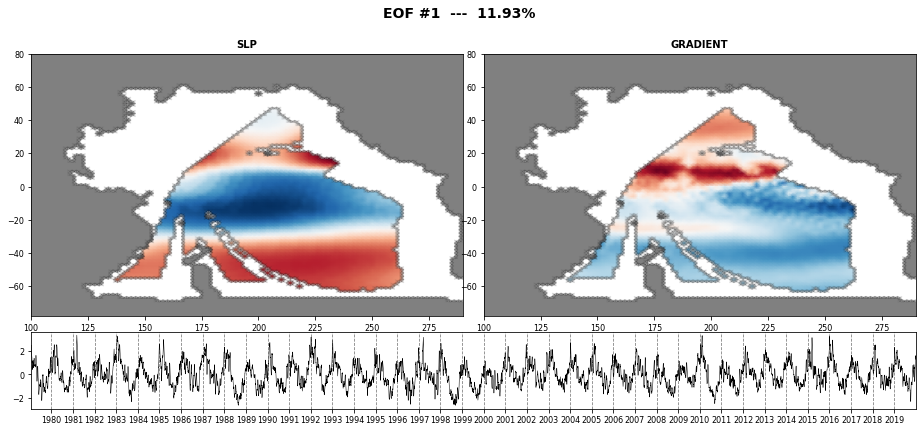

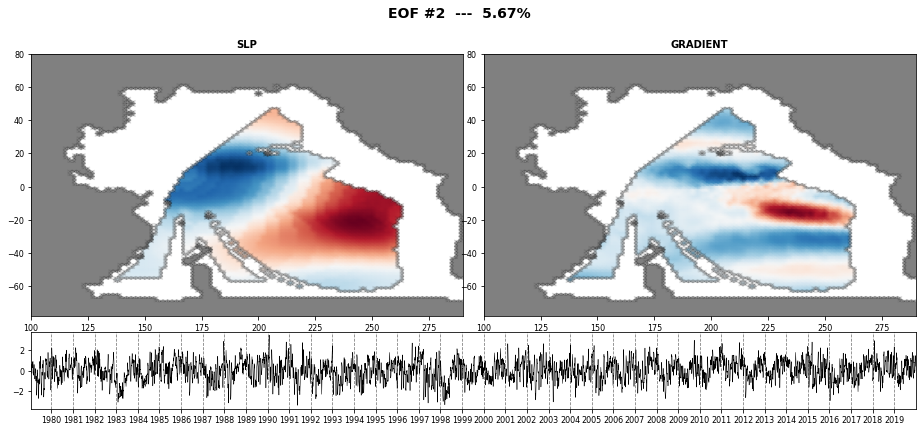

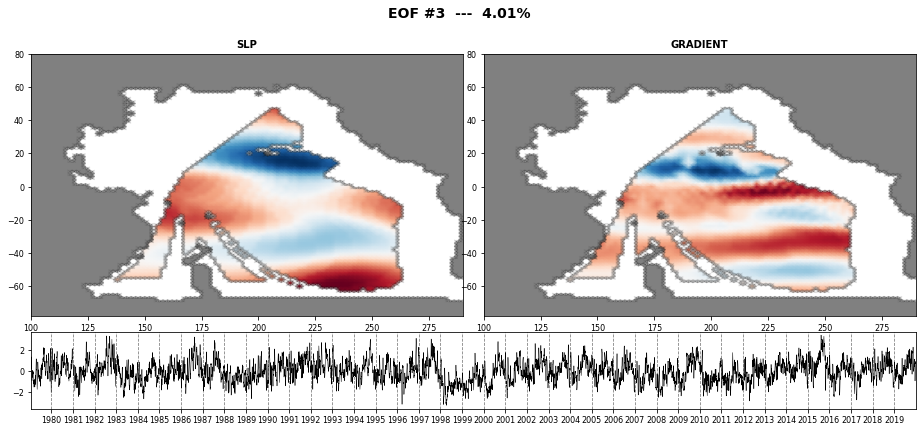

In [10]:
# plot PCA EOFs
n_EOFs = 3

pred.Plot_EOFs_EstelaPred(n_EOFs, show=True);



## ESTELA Predictor - KMeans Classification

In [5]:
# Calculate KMA (regression guided with RUNUP data)
pred.Calc_KMA_regressionguided(
    num_clusters,
    RUNUP, ['runup'],
    kmarg_alpha, min_group_size=50, repres = 0.85
)

print(pred.KMA)

<xarray.Dataset>
Dimensions:             (n_clusters: 36, n_components: 14953, n_features: 152)
Dimensions without coordinates: n_clusters, n_components, n_features
Data variables:
    bmus                (n_components) int32 ...
    cenEOFs             (n_clusters, n_features) float64 ...
    centroids           (n_clusters, n_features) float64 ...
    group_size          (n_clusters) int64 ...
    sorted_order        (n_clusters) int64 ...
    sorted_bmus         (n_components) int64 ...
    sorted_cenEOFs      (n_clusters, n_features) float64 ...
    sorted_centroids    (n_clusters, n_features) float64 ...
    time                (n_components) datetime64[ns] ...
    sorted_bmus_storms  (n_components) int64 ...
Attributes:
    method:   regression guided
    alpha:    0.3


SystemExit: 

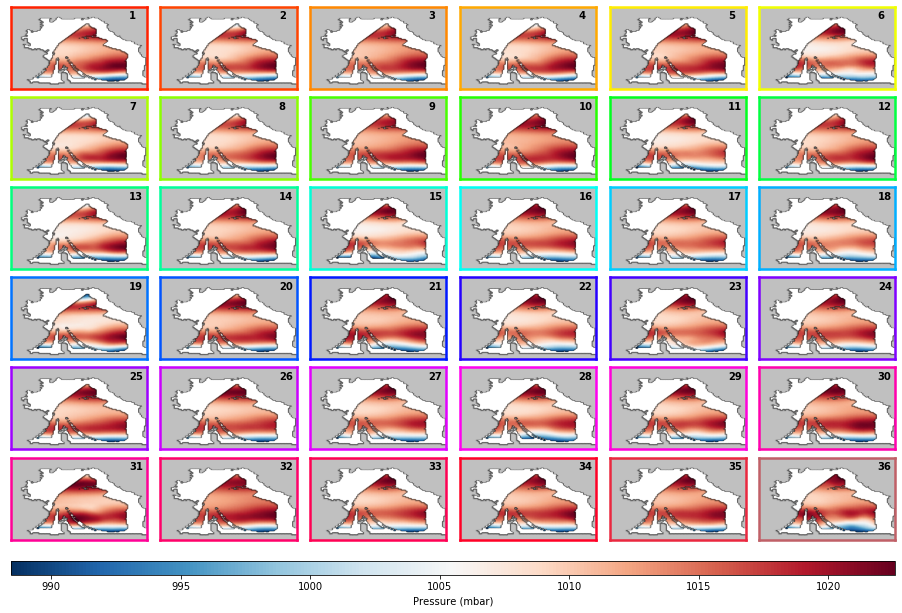

In [12]:
# Plot DWTs (data mean)
pred.Plot_DWTs('SLP', kind='mean', show=True);


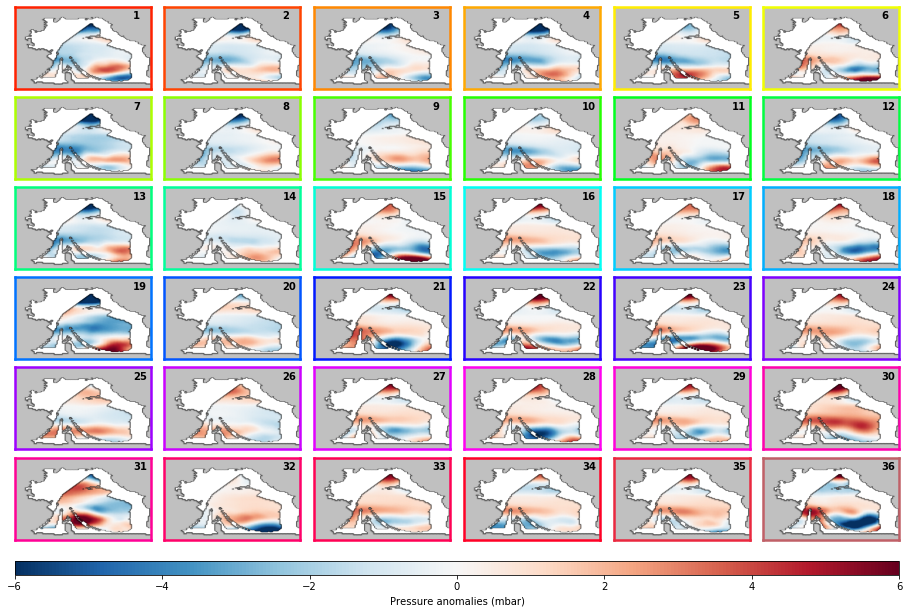

In [13]:
# Plot DWTs (data anomalies)
pred.Plot_DWTs('SLP', kind='anom', show=True);


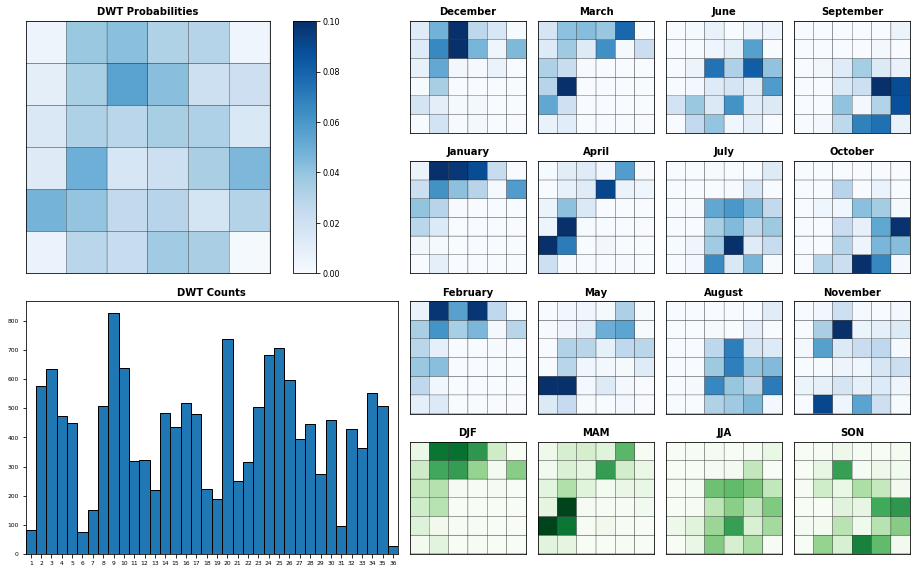

In [14]:
# Plot DWTs Probabilities
pred.Plot_DWTs_Probs();


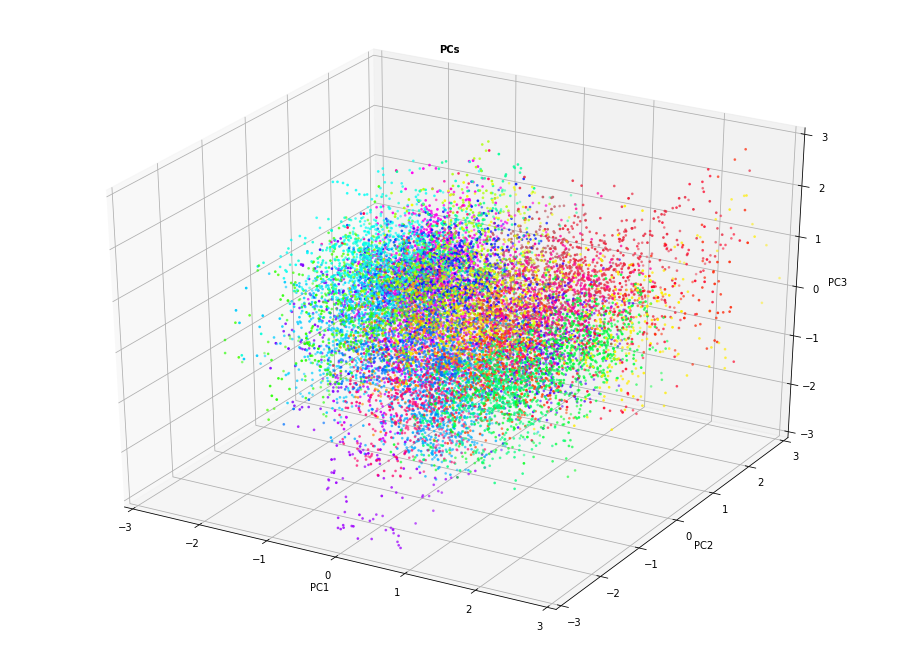

In [15]:
# Plot PC1, PC2, PC3 (3D)
pred.Plot_PCs_3D();


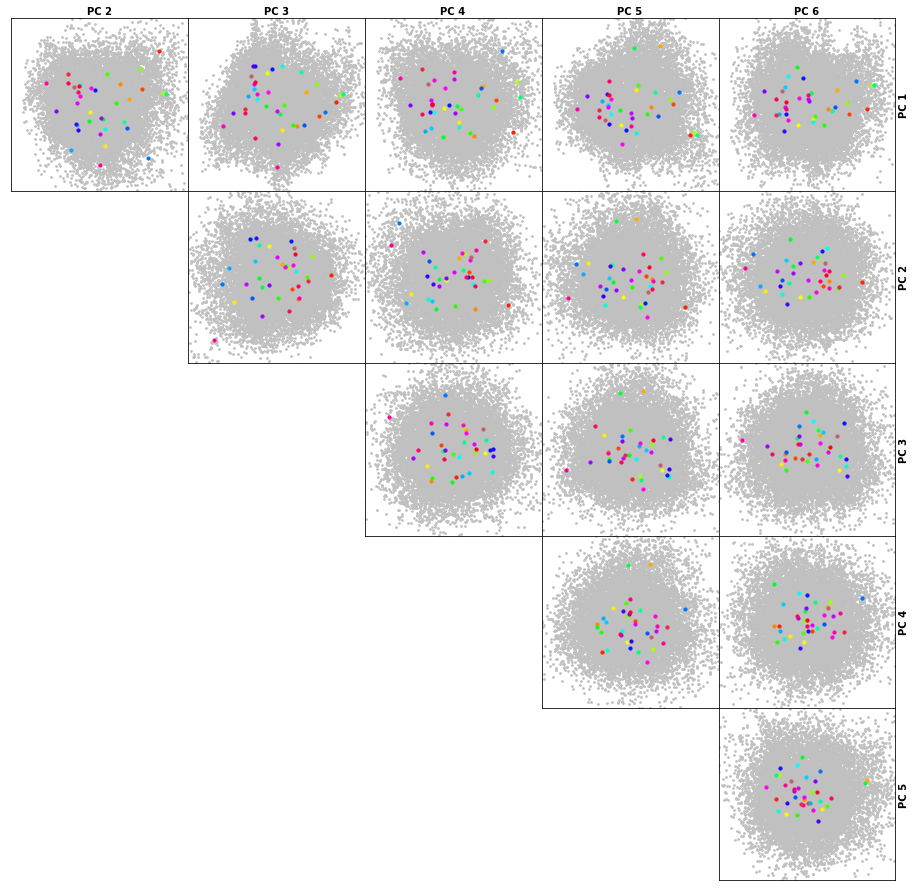

SystemExit: 

In [16]:
# Plot PCs DWT centroids
pred.Plot_DWT_PCs(n=6);




## ESTELA Predictor - Add Historical TCs

In [7]:
# --------------------------------------
# use historical storms-parameters inside r1 to modify predictor KMA results 

storm_dates = TCs_r1_params.dmin_date.values[:]
storm_categs = TCs_r1_params.category.values[:]

# add r1 storms to predictor KMA
pred.Mod_KMA_AddStorms(storm_dates, storm_categs)

print(pred.KMA)

<xarray.Dataset>
Dimensions:             (n_clusters: 36, n_components: 14953, n_features: 152)
Dimensions without coordinates: n_clusters, n_components, n_features
Data variables:
    bmus                (n_components) int32 ...
    cenEOFs             (n_clusters, n_features) float64 ...
    centroids           (n_clusters, n_features) float64 ...
    group_size          (n_clusters) int64 ...
    sorted_order        (n_clusters) int64 ...
    sorted_bmus         (n_components) int64 6 6 6 12 12 12 12 ... 7 7 7 7 7 7 7
    sorted_cenEOFs      (n_clusters, n_features) float64 ...
    sorted_centroids    (n_clusters, n_features) float64 ...
    time                (n_components) datetime64[ns] 1979-01-23 ... 2019-12-31
    sorted_bmus_storms  (n_components) int64 6 6 6 12 12 12 12 ... 7 7 7 7 7 7 7
Attributes:
    method:   regression guided
    alpha:    0.3


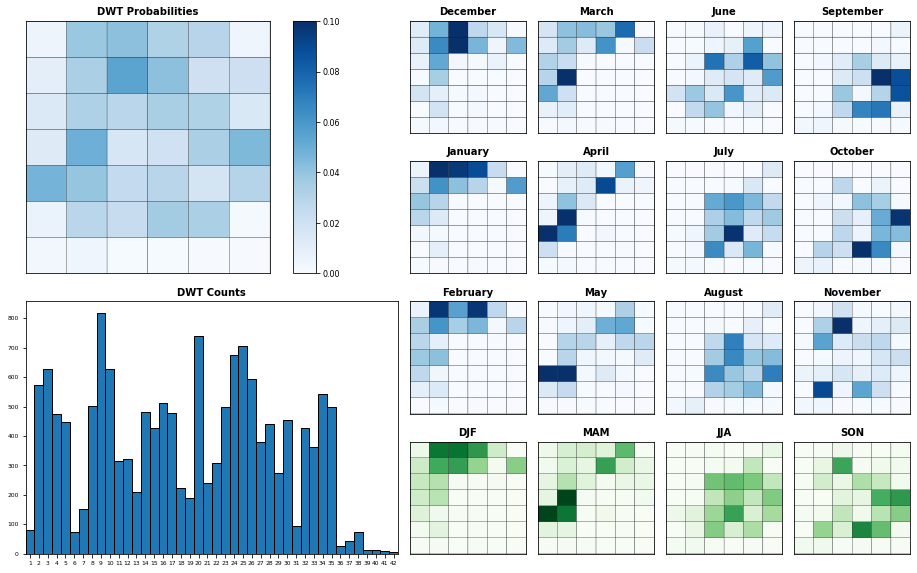

In [7]:
# Plot DWTs Probabilities with updated bmus
pred.Plot_DWTs_Probs(field='sorted_bmus_storms', n_clusters=42);


## Calculate hydrograps for nearshore waves at 3 locations (N, E, S)

In [8]:
# --------------------------------------
# Calculate intradaily MU TAU hydrographs (hourly waves and hourly runup)

# East and South have 3-hourly resolution, convert to hourly (EN REALIDAD ESTO NO AFECTA AL CÁLCULO DE MU Y TAU)
WAVES_N_h = WAVES_N.copy(deep=True)
WAVES_S_h = WAVES_S.resample(time='1H').interpolate('linear')
WAVES_E_h = WAVES_E.resample(time='1H').interpolate('linear')

WAVES_runup_N_h = WAVES_runup_N.copy(deep=True)
WAVES_runup_S_h = WAVES_runup_S.resample(time='1H').interpolate('linear')
WAVES_runup_E_h = WAVES_runup_E.resample(time='1H').interpolate('linear')


# Calculate hydrographs
xds_MU_TAU_N = pred.Calc_MU_TAU_Hydrographs_runup_hist(WAVES_N_h, WAVES_runup_N_h.runup) 
xds_MU_TAU_S = pred.Calc_MU_TAU_Hydrographs_runup_hist(WAVES_S_h, WAVES_runup_S_h.runup)
xds_MU_TAU_E = pred.Calc_MU_TAU_Hydrographs_runup_hist(WAVES_E_h, WAVES_runup_E_h.runup)

print(xds_MU_TAU_N)
print(xds_MU_TAU_S)
print(xds_MU_TAU_E)


# store hydrographs MU TAU
xds_MU_TAU_N.to_netcdf(op.join(p_data, 'sites', 'KWAJALEIN_hindcast', 'ESTELA', 'hydrographs', 'MuTau_N.nc'))
xds_MU_TAU_S.to_netcdf(op.join(p_data, 'sites', 'KWAJALEIN_hindcast', 'ESTELA', 'hydrographs', 'MuTau_S.nc'))
xds_MU_TAU_E.to_netcdf(op.join(p_data, 'sites', 'KWAJALEIN_hindcast', 'ESTELA', 'hydrographs', 'MuTau_E.nc'))



<xarray.Dataset>
Dimensions:         (time: 3625)
Coordinates:
  * time            (time) datetime64[ns] 1979-01-23 1979-01-26 ... 2019-12-23
Data variables:
    MU              (time) float64 0.7646 0.5898 0.6773 ... 0.744 0.4179 0.4117
    MU2             (time) float64 0.7756 0.7878 0.7561 ... 0.7961 0.6896 0.8678
    TAU             (time) float64 0.5556 0.2917 0.875 ... 0.4167 0.85 0.8611
    Hs              (time) float64 0.4559 0.5131 0.5096 ... 0.3451 0.6269 0.5766
    Tp              (time) float64 3.545 4.723 4.862 4.522 ... 2.95 5.244 5.046
    Dir             (time) float64 29.24 4.508 5.762 7.094 ... 36.76 3.227 4.164
    Runup_max       (time) float64 0.6607 0.8438 0.8489 ... 0.4854 1.033 0.9513
    time_runup_max  (time) datetime64[ns] 1979-01-24T15:00:00 ... 2019-12-30T17:00:00
    WT              (time) int64 6 12 2 9 7 2 9 2 9 ... 13 16 33 16 10 11 2 8 7
<xarray.Dataset>
Dimensions:         (time: 3625)
Coordinates:
  * time            (time) datetime64[ns] 1979-01-23

## Offshore wave conditions for each DWT

<xarray.Dataset>
Dimensions:      (time: 14975)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
Data variables:
    Hs           (time) float32 1.6662501 3.2777503 ... 1.7078334 2.037917
    Tp           (time) float32 5.926146 8.379675 ... 17.829004 17.197895
    Dir          (time) float32 75.36087 77.46667 ... 47.104168 39.17917
    sea_Hs       (time) float32 1.7357394 3.2762501 ... 1.3680835 1.6722502
    sea_Tp       (time) float32 5.922174 8.384167 ... 6.0112495 6.474167
    sea_Dir      (time) float32 75.347824 77.416664 130.4762 ... 58.125 55.125
    swell_1_Hs   (time) float64 nan nan 2.792 1.107 ... 0.773 0.676 0.595 0.4957
    swell_1_Tp   (time) float64 nan nan 10.04 9.783 ... 9.925 9.98 9.879 9.833
    swell_1_Dir  (time) float64 nan nan 63.4 70.21 ... 74.0 77.0 70.72 74.0
    swell_2_Hs   (time) float64 nan nan 0.8766 0.5024 ... 0.3032 0.2721 0.3022
    swell_2_Tp   (time) float64 nan nan 8.428 8.584 ... 10.98 9.605 10.27 10.23
  

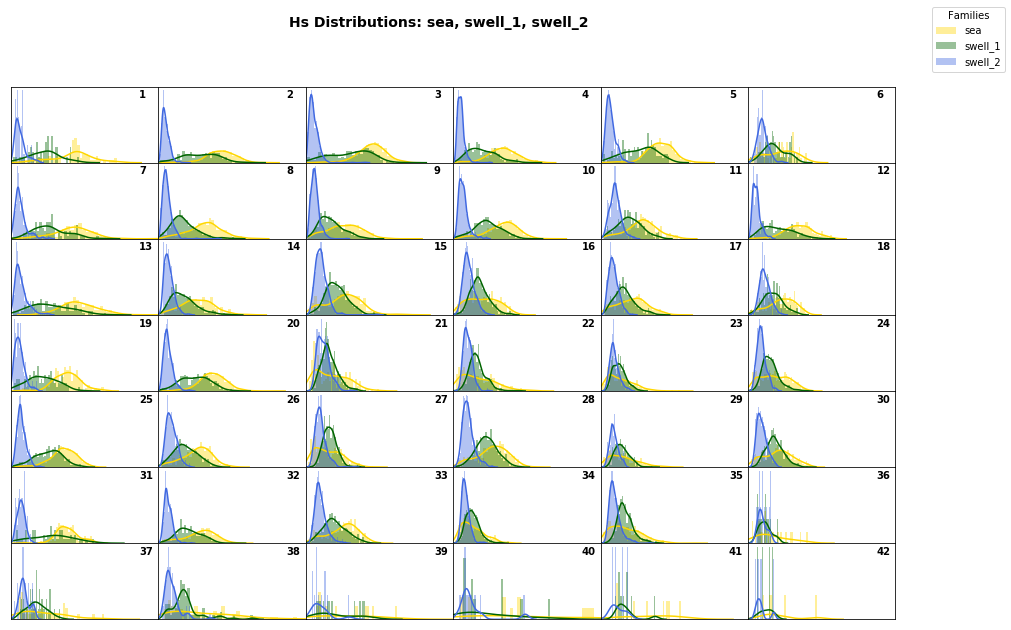

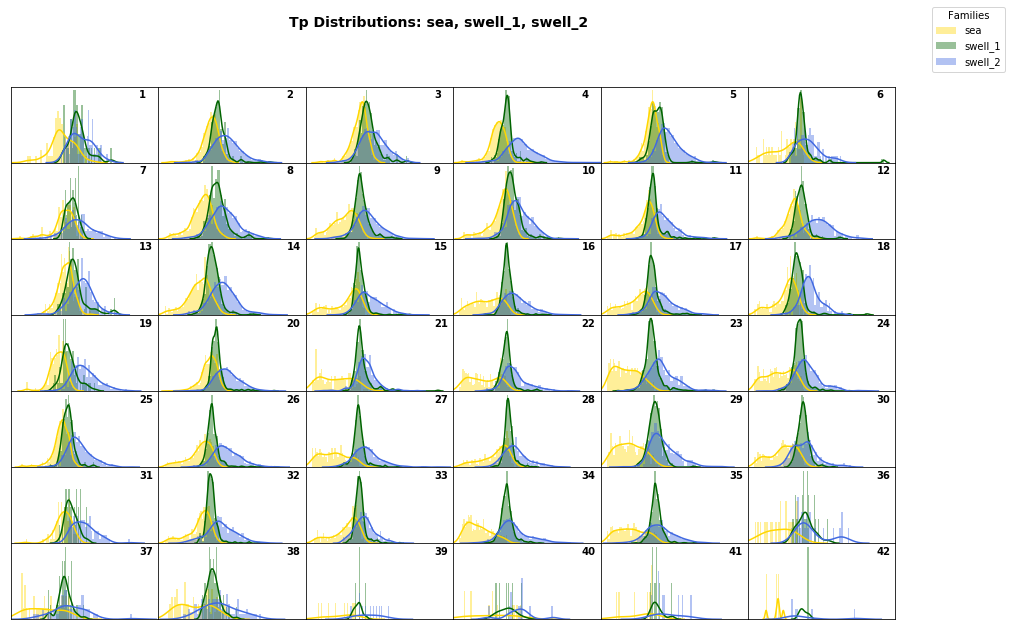

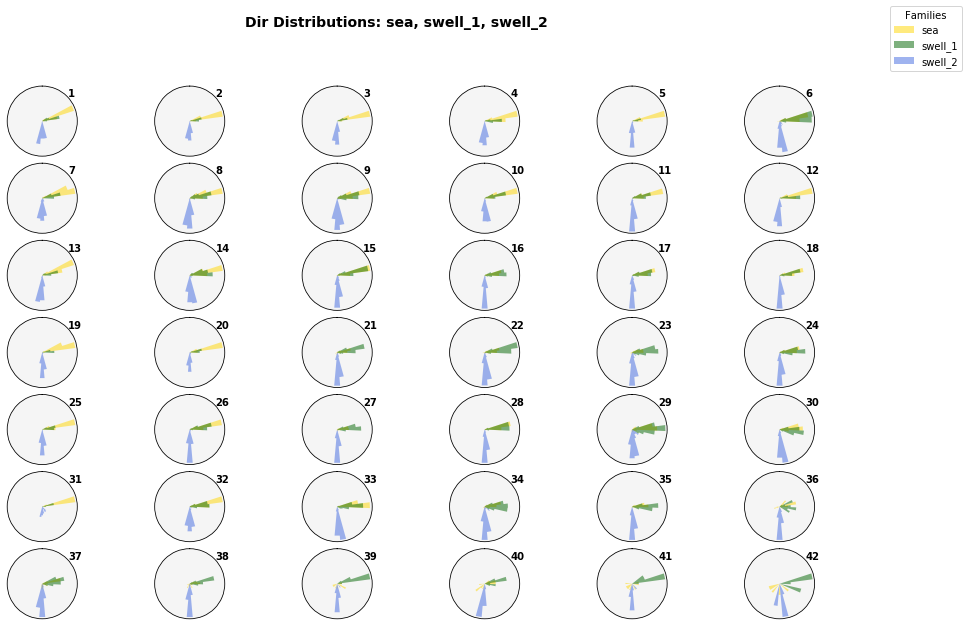

In [9]:
# Plot offshore Waves Families by DWTs (bmus for TCs do not contain TC waves but regular climate waves)

# select time window and calculate daily mean
WAVES_d = WAVES.sel(time = slice(kma_date_ini, kma_date_end)).resample(time='1D').mean()
print(WAVES_d)

# DWTs bmus
DWTs = pred.KMA
BMUS = xr.Dataset(
    {'bmus':(('time',), DWTs['sorted_bmus_storms'].values[:])},
    coords = {'time': DWTs.time.values[:]}
)
n_clusters = 42

# common dates
dates_common= xds_common_dates_daily([WAVES_d, DWTs])

# waves and bmus at common dates
WAVES_sel = WAVES_d.sel(time=dates_common)
bmus_sel = BMUS.sel(time=dates_common).bmus.values[:]

# Plot Waves Families by DWTs
Plot_Waves_DWTs(WAVES_sel, bmus_sel, n_clusters);
